In [ ]:
# import libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [ ]:
import os

# Check the contents of the mount point
print(os.listdir('/content/drive/'))


['MyDrive']


In [ ]:
import shutil

# Safely clear the mount point
shutil.rmtree('/content/drive/')
print("Mount point cleared.")

Mount point cleared.


In [ ]:
os.makedirs('/content/drive/', exist_ok=True)

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/dip dataset/fruits-360/

/content/drive/MyDrive/dip dataset/fruits-360


In [ ]:
import os
import shutil
import random
import tensorflow as tf

# Define the original dataset directories
train_dir = '/content/drive/MyDrive/dip dataset/fruits-360/Training'
temp_train_dir = '/content/drive/MyDrive/dip dataset/fruits-360/Training_Sample'

# Define how many samples you want
subset_size = 100  # Number of images per class for the subset

# Function to create a subset of the dataset
def create_subset(input_dir, output_dir, subset_size):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    for class_dir in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_dir)
        if os.path.isdir(class_path):
            os.makedirs(os.path.join(output_dir, class_dir), exist_ok=True)
            # Get a random subset of files in this class
            files = os.listdir(class_path)
            selected_files = random.sample(files, min(len(files), subset_size))
            for file_name in selected_files:
                shutil.copy(os.path.join(class_path, file_name), os.path.join(output_dir, class_dir, file_name))

# Create subsets for training and validation
create_subset(train_dir, temp_train_dir, subset_size)

# Load the subset dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    temp_train_dir,
    validation_split=0.2,
    subset='training',
    batch_size=32,
    image_size=(100, 100),
    seed=123,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    temp_train_dir,
    validation_split=0.2,
    subset='validation',
    batch_size=32,
    image_size=(100, 100),
    seed=42,
)


Found 14100 files belonging to 141 classes.
Using 11280 files for training.
Found 14100 files belonging to 141 classes.
Using 2820 files for validation.


In [ ]:
# Get the class names from the subdirectories in the training directory
class_names = sorted(os.listdir(train_dir))
# Print the class names and the number of classes
print("Class Names:", class_names)
num_classes = len(class_names)
print("Number of Classes:", num_classes)

Class Names: ['Apple 6', 'Apple Braeburn 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple hit 1', 'Apricot 1', 'Avocado 1', 'Avocado ripe 1', 'Banana 1', 'Banana Lady Finger 1', 'Banana Red 1', 'Beetroot 1', 'Blueberry 1', 'Cabbage white 1', 'Cactus fruit 1', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula 1', 'Carrot 1', 'Cauliflower 1', 'Cherry 1', 'Cherry 2', 'Cherry Rainier 1', 'Cherry Wax Black 1', 'Cherry Wax Red 1', 'Cherry Wax Yellow 1', 'Chestnut 1', 'Clementine 1', 'Cocos 1', 'Corn 1', 'Corn Husk 1', 'Cucumber 1', 'Cucumber 3', 'Cucumber Ripe 1', 'Cucumber Ripe 2', 'Dates 1', 'Eggplant 1', 'Eggplant long 1', 'Fig 1', 'Ginger Root 1', 'Granadilla 1', 'Grape Blue 1', 'Grape Pink 1', 'Grape White 1', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink 1', 'Grapefruit White

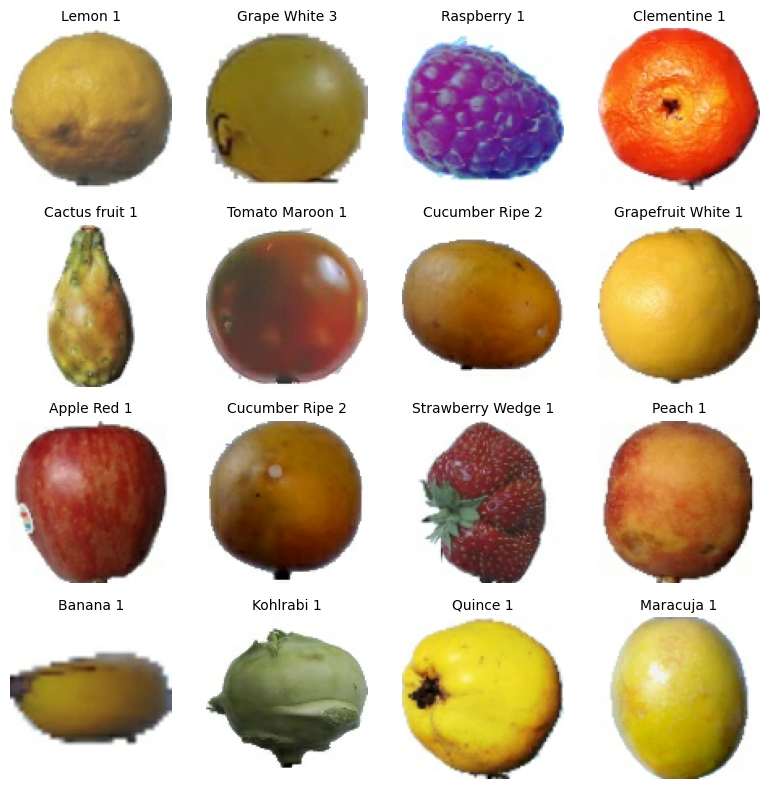

In [ ]:
def show_images(dataset, class_names, num_images=25, grid_size=(5, 5)):
    """
    Display a grid of images from a dataset.

    Parameters:
    - dataset: A TensorFlow dataset containing image-label pairs.
    - class_names: List of class names corresponding to the labels.
    - num_images: Number of images to display (default is 25).
    - grid_size: Tuple specifying grid rows and columns (default is (5, 5)).
    """
    plt.figure(figsize=(grid_size[1] * 2, grid_size[0] * 2))  # Adjust figure size based on grid

    for images, labels in dataset.take(1):  # Take one batch from the dataset
        for i in range(min(num_images, len(images))):  # Display up to the specified number of images
            ax = plt.subplot(grid_size[0], grid_size[1], i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))  # Convert to uint8 for proper display
            plt.title(class_names[labels[i]], fontsize=10)
            plt.axis("off")  # Hide axes for better visual presentation

    plt.tight_layout()  # Adjust layout to avoid overlapping
    plt.show()

# Example usage: Show images from the training dataset
show_images(train_ds, class_names, num_images=16, grid_size=(4, 4))


In [ ]:
# for faster training which takes less time and less memory for training
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# Augmentation for training dataset
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(100, 100, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 141)                 │          72,333 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,362,253 (5.20 MB)

 Trainable params: 1,362,253 (5.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define EarlyStopping callback
early_stopping = callbacks.EarlyStopping(patience=3)

# Train the model with early stopping
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the training process
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


353/353 ━━━━━━━━━━━━━━━━━━━━ 320s 776ms/step - accuracy: 0.1096 - loss: 4.2335 - val_accuracy: 0.6975 - val_loss: 1.0965
Epoch 2/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 267s 757ms/step - accuracy: 0.7584 - loss: 0.8715 - val_accuracy: 0.8773 - val_loss: 0.4329
Epoch 3/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 261s 741ms/step - accuracy: 0.8962 - loss: 0.3671 - val_accuracy: 0.9355 - val_loss: 0.2116
Epoch 4/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 264s 749ms/step - accuracy: 0.9389 - loss: 0.2130 - val_accuracy: 0.9755 - val_loss: 0.1026
Epoch 5/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 271s 767ms/step - accuracy: 0.9680 - loss: 0.1185 - val_accuracy: 0.9816 - val_loss: 0.0671
Epoch 6/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 266s 754ms/step - accuracy: 0.9689 - loss: 0.1132 - val_accuracy: 0.9777 - val_loss: 0.0999
Epoch 7/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 266s 754ms/step - accuracy: 0.9783 - loss: 0.0757 - val_accuracy: 0.9574 - val_loss: 0.2234
Epoch 8/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 319s 746ms/step - accuracy: 0.9781 - loss: 0.09

89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 200ms/step - accuracy: 0.9893 - loss: 0.0358
Validation Loss: 0.0333
Validation Accuracy: 0.9901


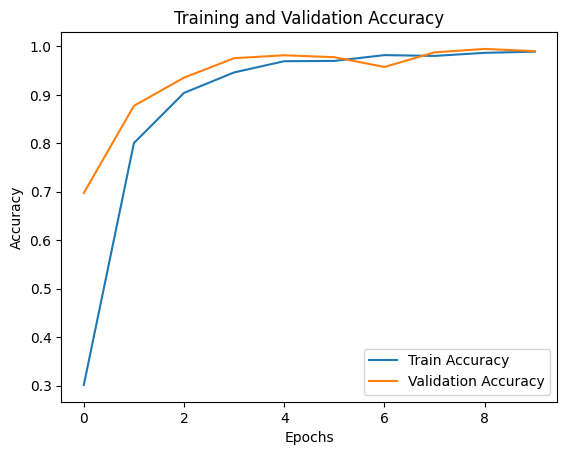

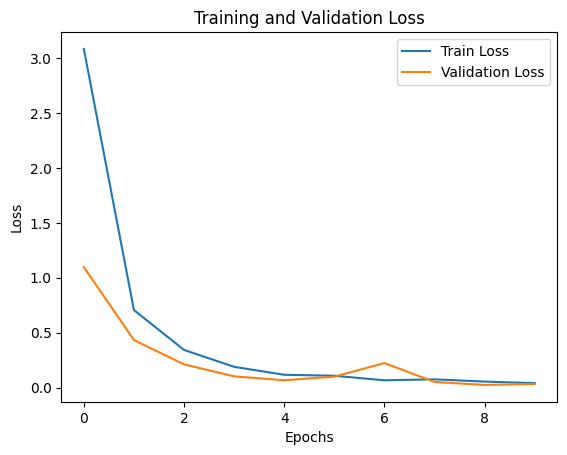

In [ ]:
# Plot training history
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Get true labels (y_true)
y_true = []
y_pred = []

for images, labels in val_ds.unbatch():
    # Append true label
    y_true.append(labels.numpy())

    # Step 2: Predict using the model
    img_array = tf.expand_dims(images, 0)  # Expand dims to make it batch-like
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])

    # Append predicted label
    y_pred.append(predicted_class_index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━

In [ ]:
y_true = [class_names[i] for i in y_true]
y_pred = [class_names[i] for i in y_pred]

cm = confusion_matrix(y_true, y_pred, labels=class_names)
print(cm)

[[20  0  0 ...  0  0  0]
 [ 0 20  0 ...  0  0  0]
 [ 0  0 19 ...  0  0  0]
 ...
 [ 0  0  0 ... 21  0  0]
 [ 0  0  0 ...  0 16  0]
 [ 0  0  0 ...  0  0 28]]


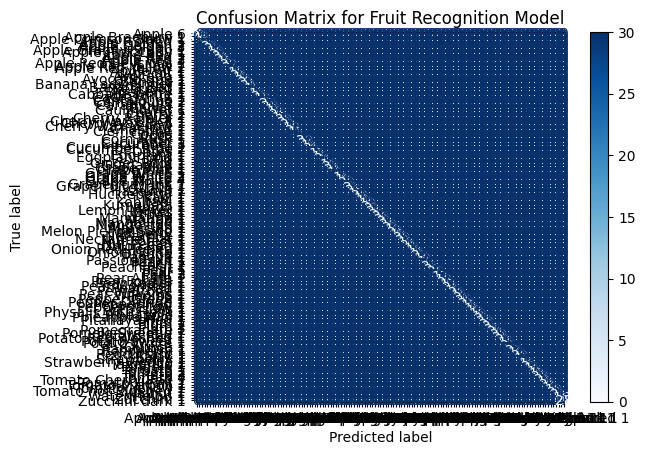

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Fruit Recognition Model")
plt.show()

In [ ]:
# Mapping classes to broader categories
category_map = {
    'Apple': ['Apple 6', 'Apple Braeburn 1', 'Apple Crimson Snow 1', 'Apple Golden 1',
              'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1',
              'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1',
              'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple hit 1'],

    'Apricot': ['Apricot 1'],

    'Avocado': ['Avocado 1', 'Avocado ripe 1'],

    'Banana': ['Banana 1', 'Banana Lady Finger 1', 'Banana Red 1'],

    'Berry': ['Blueberry 1', 'Raspberry 1', 'Strawberry 1', 'Strawberry Wedge 1', 'Redcurrant 1',
              'Huckleberry 1', 'Mulberry 1'],

    'Citrus': ['Clementine 1', 'Lemon 1', 'Lemon Meyer 1', 'Limes 1', 'Mandarine 1',
               'Orange 1', 'Grapefruit Pink 1', 'Grapefruit White 1', 'Tangelo 1', 'Pomelo Sweetie 1'],

    'Melon': ['Cantaloupe 1', 'Cantaloupe 2', 'Melon Piel de Sapo 1', 'Watermelon 1'],

    'Stone Fruit': ['Peach 1', 'Peach 2', 'Peach Flat 1', 'Nectarine 1', 'Nectarine Flat 1',
                    'Plum 1', 'Plum 2', 'Plum 3', 'Cherry 1', 'Cherry 2', 'Cherry Rainier 1',
                    'Cherry Wax Black 1', 'Cherry Wax Red 1', 'Cherry Wax Yellow 1'],

    'Grape': ['Grape Blue 1', 'Grape Pink 1', 'Grape White 1', 'Grape White 2',
              'Grape White 3', 'Grape White 4'],

    'Pineapple': ['Pineapple 1', 'Pineapple Mini 1'],

    'Tropical': ['Mango 1', 'Mango Red 1', 'Mangostan 1', 'Passion Fruit 1', 'Papaya 1',
                 'Granadilla 1', 'Maracuja 1', 'Lychee 1', 'Rambutan 1', 'Pitahaya Red 1'],

    'Vegetable': ['Carrot 1', 'Cauliflower 1', 'Cabbage white 1', 'Corn 1', 'Corn Husk 1',
                  'Eggplant 1', 'Eggplant long 1', 'Beetroot 1', 'Onion Red 1',
                  'Onion Red Peeled 1', 'Onion White 1', 'Zucchini 1', 'Zucchini dark 1',
                  'Cucumber 1', 'Cucumber 3', 'Cucumber Ripe 1', 'Cucumber Ripe 2'],

    'Root & Nuts': ['Hazelnut 1', 'Chestnut 1', 'Walnut 1', 'Potato Red 1', 'Potato Red Washed 1',
                    'Potato Sweet 1', 'Potato White 1', 'Nut Forest 1', 'Nut Pecan 1'],

    'Exotic': ['Physalis 1', 'Physalis with Husk 1', 'Salak 1', 'Pepino 1', 'Cactus fruit 1'],

    'Pepper': ['Pepper Green 1', 'Pepper Orange 1', 'Pepper Red 1', 'Pepper Yellow 1'],

    'Other Fruits': ['Fig 1', 'Guava 1', 'Kaki 1', 'Kumquats 1', 'Quince 1', 'Tomato 1',
                     'Tomato 2', 'Tomato 3', 'Tomato 4', 'Tomato Cherry Red 1',
                     'Tomato Heart 1', 'Tomato Maroon 1', 'Tomato Yellow 1',
                     'Tomato not Ripened 1', 'Dates 1'],

    'Miscellaneous': ['Ginger Root 1', 'Tamarillo 1']
}


# Reverse map to find category for each class
reverse_map = {cls: cat for cat, classes in category_map.items() for cls in classes}

In [ ]:
def predict(model, img):
    img_array = tf.keras.utils.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 0)
    return predicted_class, confidence

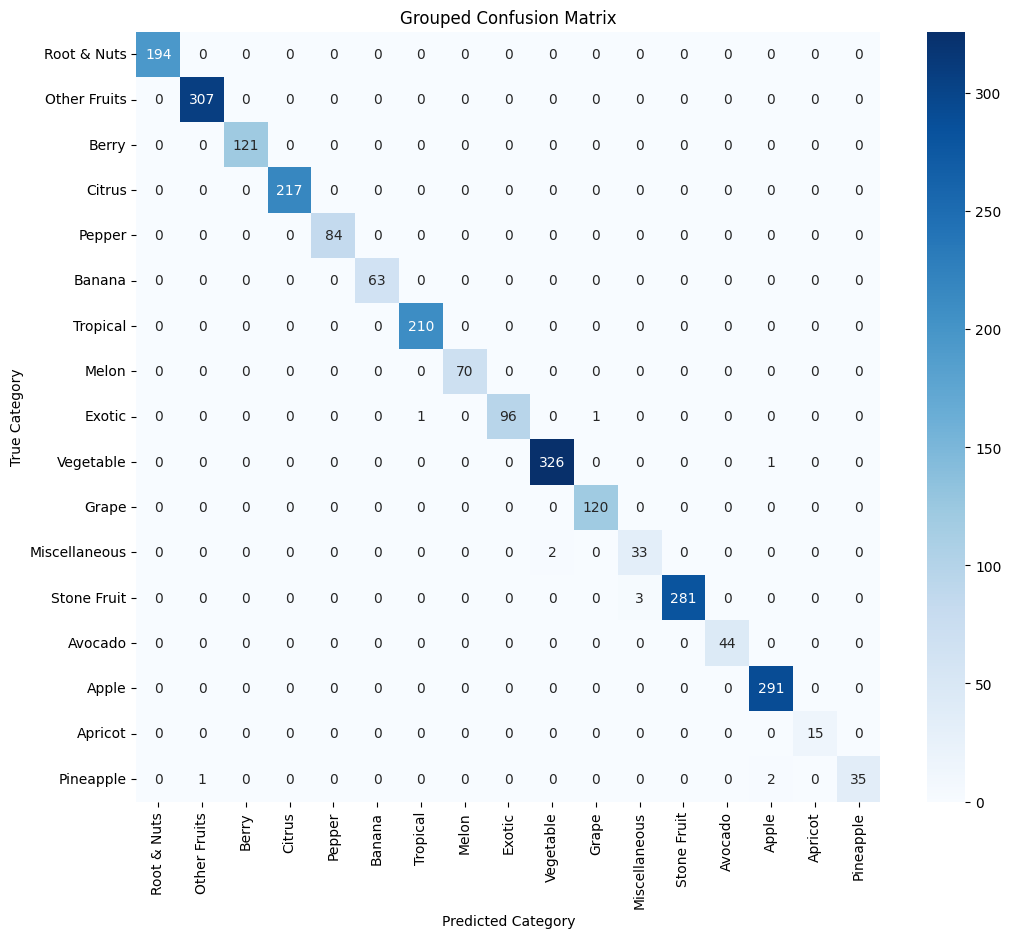

In [ ]:
# Convert y_true and y_pred to category labels
y_true_grouped = [reverse_map.get(label, label) for label in y_true]
y_pred_grouped = [reverse_map.get(label, label) for label in y_pred]

# Get the unique categories
categories = list(set(reverse_map.values()))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_true_grouped, y_pred_grouped, labels=categories)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=categories, yticklabels=categories, cmap='Blues')
plt.title("Grouped Confusion Matrix")
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


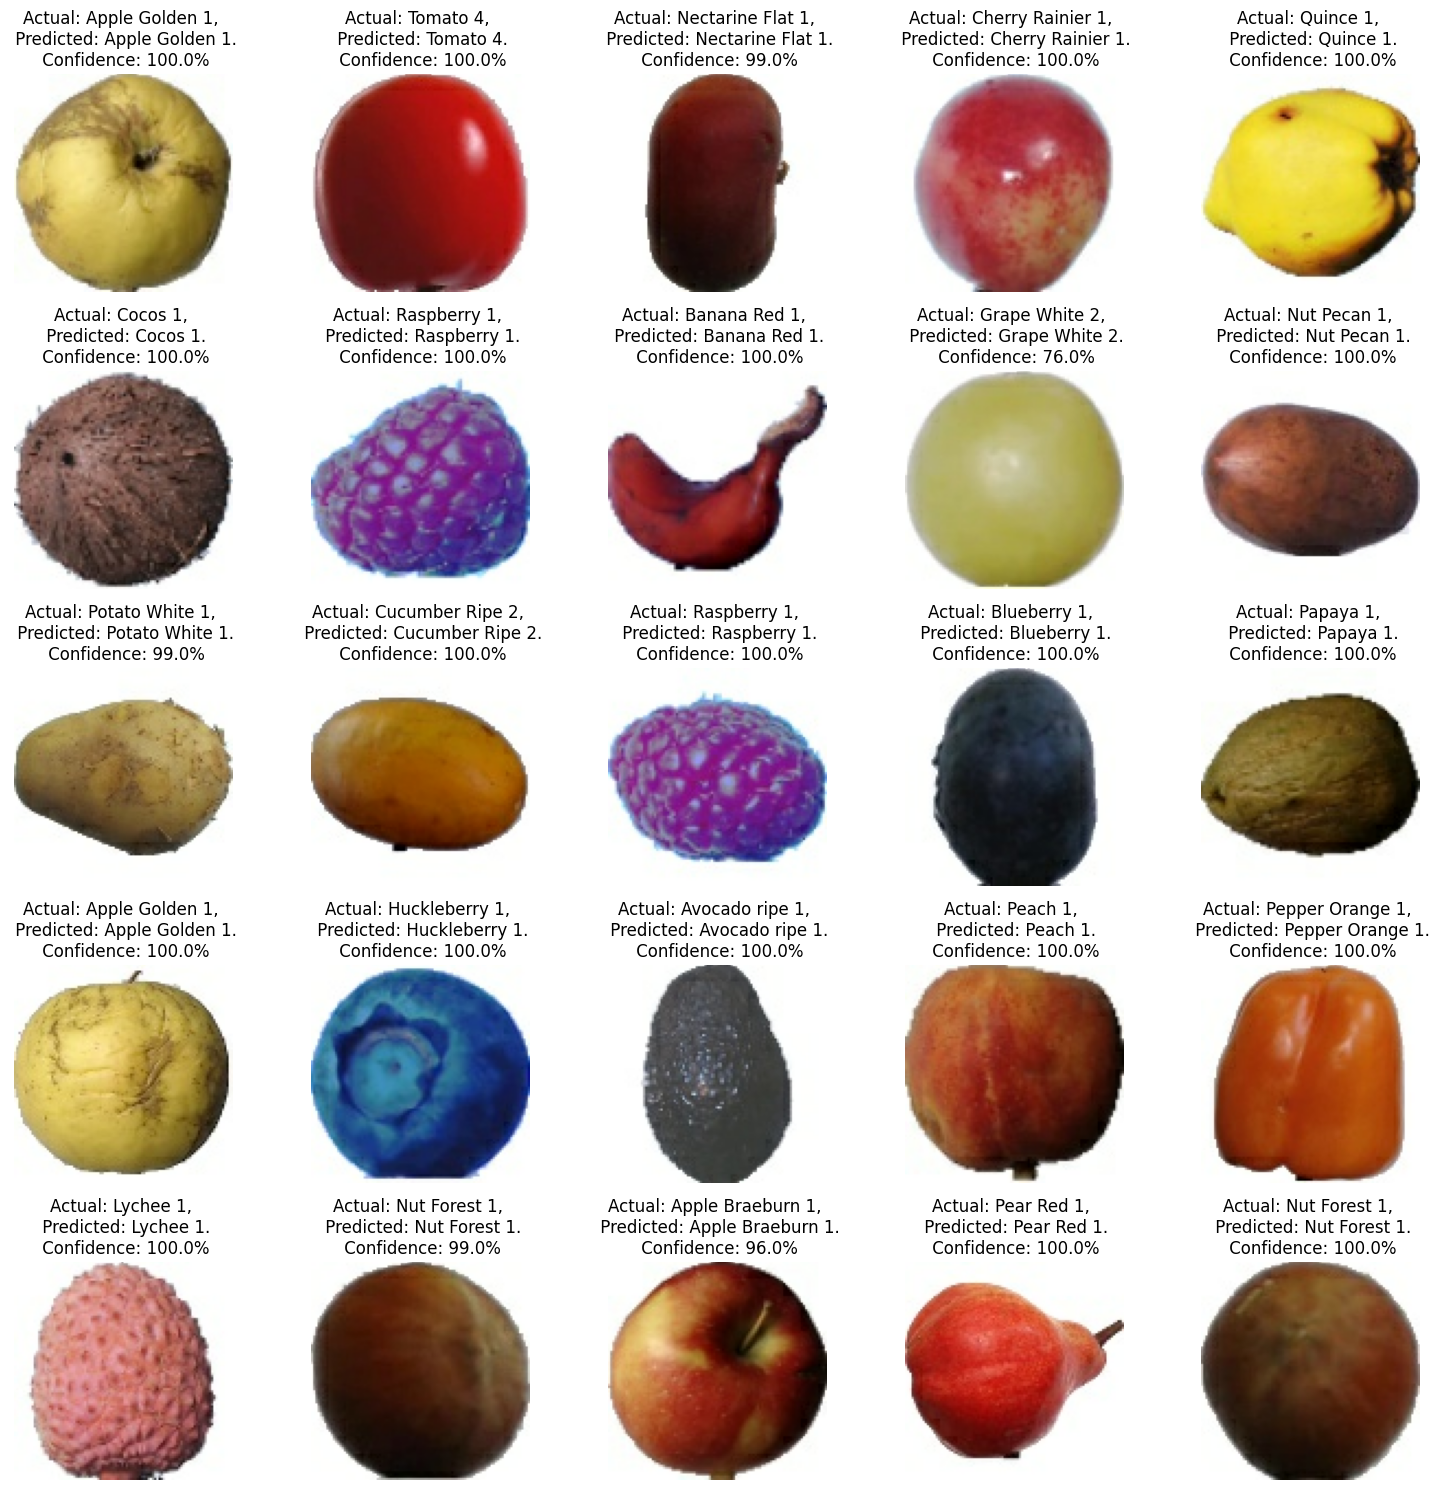

In [ ]:
import matplotlib.pyplot as plt

# Assuming val_ds is your validation dataset
plt.figure(figsize=(15, 15))
for images, labels in val_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)  # Adjust the subplot layout as per your preference
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import os
import shutil
import random
import tensorflow as tf
from sklearn.model_selection import KFold
import numpy as np

# Define the original dataset directories
train_dir = '/content/drive/MyDrive/dip dataset/fruits-360/Training'

# Define how many samples you want
subset_size = 100  # Number of images per class for the subset

# Function to create a subset of the dataset
def create_subset(input_dir, output_dir, subset_size):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    for class_dir in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_dir)
        if os.path.isdir(class_path):
            os.makedirs(os.path.join(output_dir, class_dir), exist_ok=True)
            # Get a random subset of files in this class
            files = os.listdir(class_path)
            selected_files = random.sample(files, min(len(files), subset_size))
            for file_name in selected_files:
                shutil.copy(os.path.join(class_path, file_name), os.path.join(output_dir, class_dir, file_name))

# Create subsets for training and validation
temp_train_dir = '/content/drive/MyDrive/dip dataset/fruits-360/Training_Sample'
create_subset(train_dir, temp_train_dir, subset_size)

# Load the dataset (all data, not split into training/validation yet)
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    temp_train_dir,
    image_size=(100, 100),
    batch_size=32,
    shuffle=True,
    seed=123
)


Found 14100 files belonging to 141 classes.


In [ ]:
# After training the model
model.save("model.h5")  # Save in HDF5 format

In [ ]:
import os
print(os.getcwd())  # Check the current directory

/content/drive/MyDrive/dip dataset/fruits-360


In [ ]:
model.save('my_model.keras')

In [ ]:
image_file = '/content/drive/MyDrive/Copy of 274_100.jpg'
print(f"Image file path: {image_file}")

Image file path: /content/drive/MyDrive/Copy of 274_100.jpg


In [ ]:
import os
image_path = '/content/drive/MyDrive'
print("Files in directory:", os.listdir(image_path))


Files in directory: ['Classroom', 'DocScanner Dec 14, 2022 11-34.pdf', 'DocScanner Dec 14, 2022 11-39.pdf', 'Ajay remission form (1).pdf', 'Ajay remission form.pdf', 'Ajay undertaking form  (1).pdf', 'Ajay undertaking form .pdf', 'Ajay msm.pdf', 'pass book photo (dad).pdf', 'hostel fee payment fee.pdf', 'ABC digilocker ID card .pdf', 'Print ', 'Ajay income certificate.pdf', '03_circuit_fundamentals_3.gdoc', 'AJAY PASSBOOK.pdf', 'Colab Notebooks', 'ADDEpalli Ajay Sai.pdf', 'lec2.gdoc', 'Electrical Machines : Ansys Electronics Simulation.pdf', 'L1 (1).gdoc', 'L2 (1).gdoc', 'Untitled document (4).gdoc', 'IMG20240825081117.jpg', 'Untitled spreadsheet (1).gsheet', 'B. P. Lathi, Zhi Ding - Modern Digital and Analog Communication Systems.gdoc', 'L1.gdoc', 'L2.gdoc', 'Lecture 2 - Signals and Systems.gdoc', 'Lecture 3 - Fourier Series.gdoc', 'Lecture 4 - Fourier Transform.gdoc', 'Lecture 6 - Spectral Densities.gdoc', 'Lecture 5 - Frequency Response of LTI Systems.gdoc', 'Lecture 7 - Autocorrela

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras import layers, models
from tensorflow.keras import callbacks
import gc  # For garbage collection

# Number of folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store results for each fold
accuracies = []

# Define your model architecture
def create_model():
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=(100, 100, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(len(np.unique(full_ds.class_names)), activation='softmax')  # Dynamically use number of classes
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # 'from_logits=False' since softmax is used
        metrics=['accuracy']
    )
    return model

# Data augmentation pipeline for the training dataset
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

# Convert the full_ds into numpy arrays for k-fold splitting
image_list = []
label_list = []

for image, label in full_ds:
    image_list.append(image.numpy())
    label_list.append(label.numpy())

# Convert to numpy arrays
image_list = np.concatenate(image_list, axis=0)
label_list = np.concatenate(label_list, axis=0)

# Perform k-fold cross-validation with the optimizations
for fold, (train_index, val_index) in enumerate(kf.split(image_list)):
    X_train, X_val = image_list[train_index], image_list[val_index]
    y_train, y_val = label_list[train_index], label_list[val_index]

    # Convert numpy arrays back to TensorFlow Dataset
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

    # Apply data augmentation to the training dataset
    train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Prefetch for better performance
    train_ds = train_ds.cache().shuffle(1000).batch(16).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  # Reduced batch size
    val_ds = val_ds.cache().batch(16).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    # Create and train the model for each fold
    model = create_model()

    # Define EarlyStopping callback
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3)

    # Train the model
    model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[early_stopping])

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(val_ds)
    accuracies.append(val_accuracy)
    print(f"Fold {fold+1} - Validation accuracy: {val_accuracy:.4f}")

    # Clear the model and reset TensorFlow session to free up memory
    del model
    tf.keras.backend.clear_session()

    # Run garbage collection to free unused memory
    gc.collect()

# Average the results
average_accuracy = np.mean(accuracies)
print(f"Average cross-validation accuracy: {average_accuracy:.4f}")


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


705/705 ━━━━━━━━━━━━━━━━━━━━ 309s 428ms/step - accuracy: 0.0990 - loss: 4.1624 - val_accuracy: 0.5699 - val_loss: 1.4284
Epoch 2/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 291s 387ms/step - accuracy: 0.6116 - loss: 1.3058 - val_accuracy: 0.7755 - val_loss: 0.8135
Epoch 3/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 268s 380ms/step - accuracy: 0.7765 - loss: 0.7375 - val_accuracy: 0.8262 - val_loss: 0.5836
Epoch 4/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 331s 393ms/step - accuracy: 0.8495 - loss: 0.4884 - val_accuracy: 0.8585 - val_loss: 0.5023
Epoch 5/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 265s 376ms/step - accuracy: 0.8786 - loss: 0.3817 - val_accuracy: 0.8996 - val_loss: 0.3080
Epoch 6/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 312s 361ms/step - accuracy: 0.8996 - loss: 0.3028 - val_accuracy: 0.9273 - val_loss: 0.2425
Epoch 7/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 260s 359ms/step - accuracy: 0.9179 - loss: 0.2611 - val_accuracy: 0.9177 - val_loss: 0.2543
Epoch 8/10
705/705 ━━━━━━━━━━━━━━━━━━━━ 261s 358ms/step - accuracy: 0.9343 - loss: 0.19

In [ ]:
import numpy as np
import cv2
import os

# Convert dataset to numpy arrays for applying DCT
image_list = []
label_list = []

for image, label in train_ds:
    image_list.append(image.numpy())
    label_list.append(label.numpy())

# Convert to numpy arrays
image_list = np.concatenate(image_list, axis=0)
label_list = np.concatenate(label_list, axis=0)

# Apply Discrete Cosine Transform (DCT) to images
def apply_dct(image):
    # Resize image to 100x100 if it's not already (adjust based on your dataset's dimensions)
    image = cv2.resize(image, (100, 100))
    # Convert the image from RGB to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply DCT
    dct_image = cv2.dct(np.float32(gray_image))
    # Normalize DCT coefficients (scaling to [0, 1])
    dct_image = np.abs(dct_image) / np.max(np.abs(dct_image))  # Optional: rescale DCT coefficients
    return np.reshape(dct_image, (100, 100, 1))

# Apply DCT to all images in the training dataset
dct_images_train = np.array([apply_dct(image) for image in image_list])

# Apply DCT to all images in the validation dataset
image_list_val = []
label_list_val = []

for image, label in val_ds:
    image_list_val.append(image.numpy())
    label_list_val.append(label.numpy())

image_list_val = np.concatenate(image_list_val, axis=0)
label_list_val = np.concatenate(label_list_val, axis=0)

dct_images_val = np.array([apply_dct(image) for image in image_list_val])

# Create TensorFlow datasets from the DCT transformed images
train_ds_dct = tf.data.Dataset.from_tensor_slices((dct_images_train, label_list))
val_ds_dct = tf.data.Dataset.from_tensor_slices((dct_images_val, label_list_val))

# Prefetch for better performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds_dct = train_ds_dct.cache().shuffle(1000).batch(32).prefetch(buffer_size=AUTOTUNE)
val_ds_dct = val_ds_dct.cache().batch(32).prefetch(buffer_size=AUTOTUNE)

# Simplified Model Architecture (for grayscale DCT images)
def create_simple_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(100, 100, 1)),  # DCT images are single-channel (grayscale)
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(len(np.unique(label_list)), activation='softmax')  # Adjust to number of classes
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

# Create and train the model
model = create_simple_model()

# Train the model
history = model.fit(
    train_ds_dct,
    epochs=20,
    validation_data=val_ds_dct
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_ds_dct)
print(f"Validation accuracy: {val_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


353/353 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.0113 - loss: 4.9033 - val_accuracy: 0.0716 - val_loss: 4.0896
Epoch 2/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1173 - loss: 3.7880 - val_accuracy: 0.2426 - val_loss: 3.0185
Epoch 3/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2527 - loss: 2.9105 - val_accuracy: 0.2723 - val_loss: 2.6820
Epoch 4/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3439 - loss: 2.4492 - val_accuracy: 0.3950 - val_loss: 2.1974
Epoch 5/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4051 - loss: 2.1832 - val_accuracy: 0.4309 - val_loss: 2.0558
Epoch 6/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4625 - loss: 1.9596 - val_accuracy: 0.5074 - val_loss: 1.7876
Epoch 7/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4911 - loss: 1.8438 - val_accuracy: 0.5713 - val_loss: 1.6390
Epoch 8/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5376 - loss: 1.6694 - val_accuracy: 0.58

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7420 - loss: 0.9106
Validation Loss: 0.8685
Validation Accuracy: 0.7457


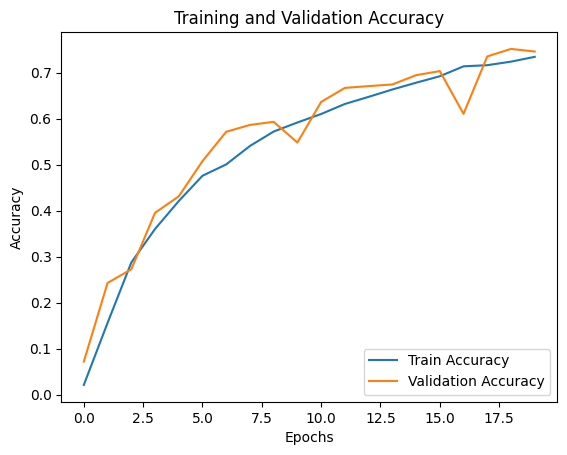

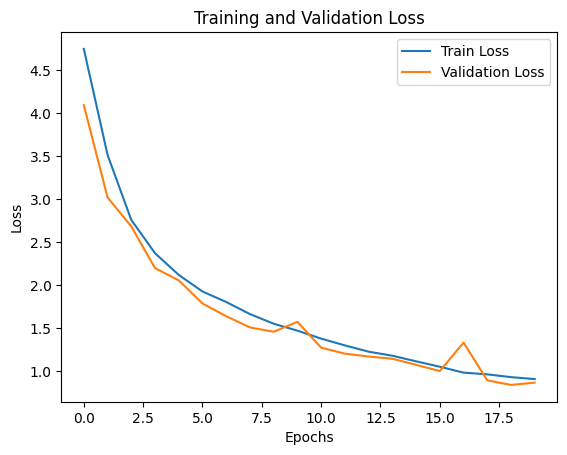

In [ ]:
# Plot training history
val_loss, val_accuracy = model.evaluate(val_ds_dct)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()